# Firing rate at different positions

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path
import numpy as np
import pandas as pd
from scipy import stats
import pickle

from dataloader import BaseDataset
from utils.plot_utils import label_diff
from utils.util import get_place_cell
from param import *

mi_dir = ParamDir().OUTPUT_ROOT / "data_exploration/"

In [5]:

spikes_at_position_all = []
mouse_type_list = []
cell_type_list = []
ratio_all = []
for data_dir in ParamDir().data_list:

    data_name = str(data_dir).split('/')[-1]
    mouse_type = "KO" if "KO" in data_name else "WT"

    # mutual information
    with open(mi_dir/data_name/"MI_all.pickle","rb") as f:
        results_all = pickle.load(f)
    pc_beh_id, _ = get_place_cell(results_all, 0.01)

    dataset = BaseDataset(data_dir, ParamData().mobility, ParamData().shuffle, ParamData().random_state)
    position = dataset._discretize_coords()

    # ratio of each position
    classes, count = np.unique(position, return_counts=True)
    ratio = count/np.sum(count) 
    ratio_all.append([ratio, mouse_type])      

    # mean firing rate at each position
    # -- group spikes by position
    _, n_neuron = dataset.spikes.shape
    df = pd.DataFrame(np.hstack([position.reshape(-1,1), dataset.spikes]))
    df.columns = ["position"]+[i for i in range(n_neuron)]
    df_group = df.groupby("position").sum()
    # -- cal firing rate by position
    for row_i , row in df_group.iterrows():
        df_group.iloc[row_i-1]= row/(count[row_i-1]/3)
    spikes_at_position_all.extend(df_group.T.values)
    mouse_type_list.extend([f"{mouse_type}"]*n_neuron)
    cell_type_list.extend(["pc" if i in pc_beh_id else "np" for i in range(n_neuron)])



In [14]:
df_spikes_on_position_all = pd.DataFrame(spikes_at_position_all, columns=[str(i+1) for i in range(len(count))])
df_spikes_on_position_all["mouse type"] = mouse_type_list
df_spikes_on_position_all["cell type"] = cell_type_list
mean_spikes_at_position = df_spikes_on_position_all.groupby(["mouse type", "cell type"]).mean()
std_spikes_at_position = df_spikes_on_position_all.groupby(["mouse type", "cell type"]).std()

ind = [str(i+1) for i in range(len(count))]

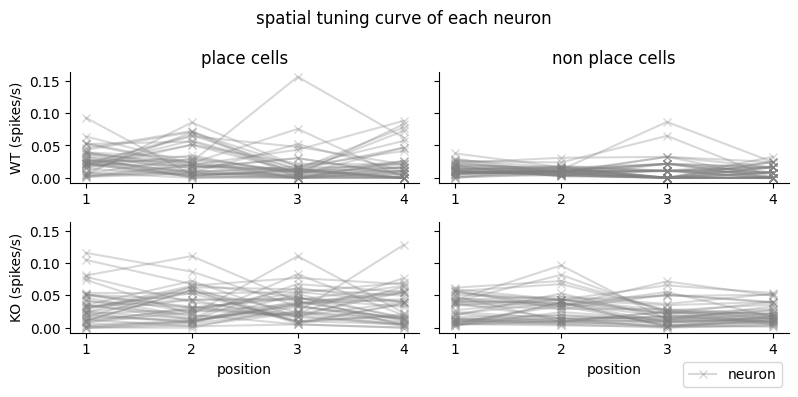

In [90]:
fig, axes = plt.subplots(ncols=2, nrows=2, figsize=(8,4), tight_layout=True, sharey=True)
sns.despine()
axes = axes.ravel()
plot_types = [("WT", "pc"), ("WT", "np"), ("KO", "pc"), ("KO", "np")]
for i, ax in enumerate(axes):
    filt = df_spikes_on_position_all[(df_spikes_on_position_all["mouse type"]==plot_types[i][0])&(df_spikes_on_position_all["cell type"]==plot_types[i][1])].iloc[:40,:4]
    filt.T.plot(ax=ax, color ="grey", alpha=.3, marker="x")
    line = ax.get_legend().get_lines()[0]
    ax.get_legend().remove()


axes[0].set_ylabel("WT (spikes/s)")
axes[2].set_ylabel("KO (spikes/s)")

axes[0].set_title("place cells")
axes[1].set_title("non place cells")

axes[2].set_xlabel("position")
axes[3].set_xlabel("position")

plt.suptitle("spatial tuning curve of each neuron")
plt.legend([line],["neuron"], bbox_to_anchor=(1,-.2))



In [78]:
filt.T.plot(ax=ax, color ="grey", alpha=.3, marker="x")
r = ax.get_legend()
ax.get_legend().remove()


In [83]:
r.get_lines()[0]